In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('./introduction.ipynb'))))

In [2]:
# Helper imports 
import numpy as np
from numpy.random import binomial, multivariate_normal, normal, uniform
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
import matplotlib.pyplot as plt
import pandas as pd

from ylearn.estimator_model.meta_learner import SLearner, TLearner, XLearner
from ylearn.estimator_model.doubly_robust import DoublyRobust
from ylearn.utils import to_df
%matplotlib inline


In [3]:
v = np.random.normal(size=(1000, 10))
y = np.hstack([v[:, [0]] < 0, v[:, [0]] > 0])

data = to_df(v=v)
covariate = data.columns

In [4]:
y

array([[ True, False],
       [ True, False],
       [ True, False],
       ...,
       [False,  True],
       [False,  True],
       [ True, False]])

In [5]:
from ylearn.effect_interpreter.policy_interpreter import PolicyInterpreter
pit = PolicyInterpreter(max_depth=2)
pit.fit(data=data, est_model=None, covariate=covariate, effect_array=y.astype(float))

pit_result = pit.interpret()

08-24 15:04:31 I ylearn.p.policy_model.py 450 - Start building the policy tree with criterion PRegCriteria
08-24 15:04:31 I ylearn.p.policy_model.py 466 - Building the policy tree with splitter BestSplitter
08-24 15:04:31 I ylearn.p.policy_model.py 498 - Building the policy tree with builder DepthFirstTreeBuilder


In [6]:
for i in range(57, 59):
    print(f'the policy for the sample {i}\n --------------\n' + pit_result[f'sample_{i}'] + '\n')

the policy for the sample 57
 --------------
decision node 0: (covariate [57, 0] = -0.0948629081249237) <= 8.582111331634223e-05 
decision node 1: (covariate [57, 8] = 1.044342041015625) > -2.3793461322784424 
The recommended policy is treatment 0 with value 1.0

the policy for the sample 58
 --------------
decision node 0: (covariate [58, 0] = 0.706959068775177) > 8.582111331634223e-05 
decision node 4: (covariate [58, 5] = 0.9160318374633789) > -2.575441598892212 
The recommended policy is treatment 1 with value 1.0



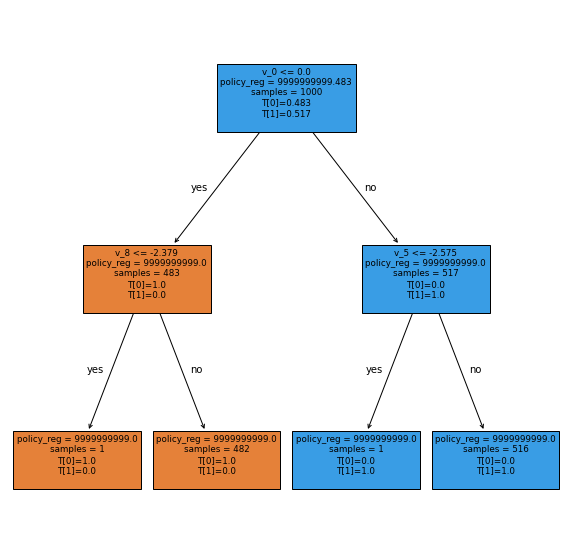

In [7]:
pit.plot()
plt.show()

In [8]:
from ylearn.estimator_model.double_ml import DML4CATE

In [9]:
X = np.random.normal(size=(1000, 10))
T = np.random.binomial(2, .5, size=(1000,))
y = (X[:, 0]) * (T==1) + (-X[:, 0]) * (T==2) 
dt = to_df(v=X, treatment=T, outcome=y)
covariate = dt.columns[:10]

In [10]:
xl = XLearner(model=RandomForestRegressor())
xl.fit(data=dt, outcome='outcome', treatment='treatment', covariate=covariate)

XLearner(model=RandomForestRegressor(), kwargs=None)

In [11]:
pit1 = PolicyInterpreter(max_depth=2)
pit1.fit(
    data=data,
    est_model=xl,
)

08-24 15:04:32 I ylearn.p.policy_model.py 450 - Start building the policy tree with criterion PRegCriteria
08-24 15:04:32 I ylearn.p.policy_model.py 466 - Building the policy tree with splitter BestSplitter
08-24 15:04:32 I ylearn.p.policy_model.py 498 - Building the policy tree with builder DepthFirstTreeBuilder


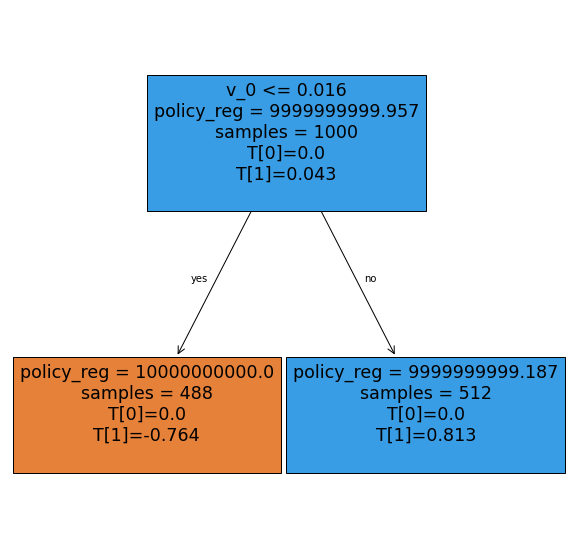

In [12]:
pit1.plot()
plt.show()

In [13]:
pit1_result = pit1.interpret()
for i in range(57, 60):
    print(f'the policy for the sample {i}\n --------------\n' + pit1_result[f'sample_{i}'] + '\n')

the policy for the sample 57
 --------------
decision node 0: (covariate [57, 0] = -0.0948629081249237) <= 0.016014338470995426 
The recommended policy is treatment 0 with value 0.0

the policy for the sample 58
 --------------
decision node 0: (covariate [58, 0] = 0.706959068775177) > 0.016014338470995426 
The recommended policy is treatment 1 with value 0.8131501795361692

the policy for the sample 59
 --------------
decision node 0: (covariate [59, 0] = -1.1887682676315308) <= 0.016014338470995426 
The recommended policy is treatment 0 with value 0.0



In [14]:
dml = DML4CATE(
    x_model=RandomForestClassifier(),
    y_model=RandomForestRegressor(),
    is_discrete_treatment=True,
)
dml.fit(data=dt, outcome='outcome', treatment='treatment', covariate=covariate)

08-24 15:04:32 I ylearn.e.double_ml.py 686 - _fit_1st_stage: fitting x_model RandomForestClassifier
08-24 15:04:32 I ylearn.e.double_ml.py 691 - _fit_1st_stage: fitting y_model RandomForestRegressor
08-24 15:04:32 I ylearn.e.double_ml.py 716 - _fit_2nd_stage: fitting yx_model LinearRegression


DML4CATE(x_model=RandomForestClassifier(), y_model=RandomForestRegressor(), yx_model=LinearRegression(), is_discrete_treatment=True)

In [15]:
pit2 = PolicyInterpreter(max_depth=2,)
pit2.fit(
    data=dt,
    est_model=dml,
    covariate=covariate,
)
pit2_result = pit2.interpret()

for i in range(57, 60):
    print(f'the policy for the sample {i}\n --------------\n' + pit2_result[f'sample_{i}'] + '\n')

08-24 15:04:32 I ylearn.p.policy_model.py 450 - Start building the policy tree with criterion PRegCriteria
08-24 15:04:32 I ylearn.p.policy_model.py 466 - Building the policy tree with splitter BestSplitter
08-24 15:04:32 I ylearn.p.policy_model.py 498 - Building the policy tree with builder DepthFirstTreeBuilder
the policy for the sample 57
 --------------
decision node 0: (covariate [57, 0] = 0.3002069294452667) > -0.0036253638099879026 
decision node 4: (covariate [57, 0] = 0.3002069294452667) > 0.01706891693174839 
The recommended policy is treatment 1 with value 0.7934152993811182

the policy for the sample 58
 --------------
decision node 0: (covariate [58, 0] = -1.486793041229248) <= -0.0036253638099879026 
decision node 1: (covariate [58, 0] = -1.486793041229248) <= -0.0306847570464015 
The recommended policy is treatment 2 with value 0.8124548816093429

the policy for the sample 59
 --------------
decision node 0: (covariate [59, 0] = 0.0721101313829422) > -0.00362536380998790

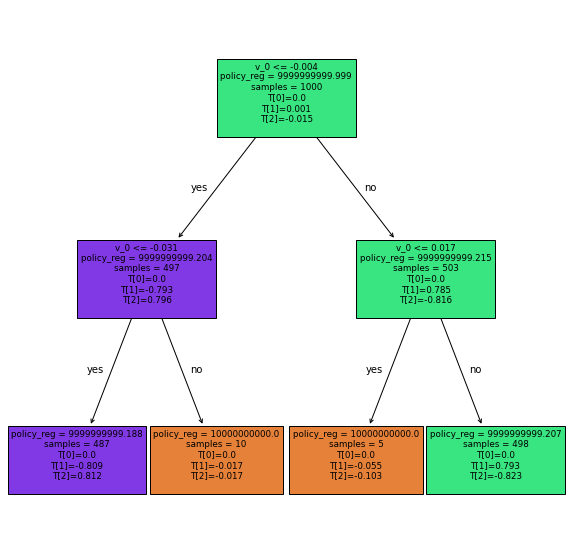

In [16]:
pit2.plot()
plt.show()

08-24 15:04:33 I ylearn.p.policy_model.py 450 - Start building the policy tree with criterion PRegCriteria
08-24 15:04:33 I ylearn.p.policy_model.py 466 - Building the policy tree with splitter BestSplitter
08-24 15:04:33 I ylearn.p.policy_model.py 498 - Building the policy tree with builder DepthFirstTreeBuilder


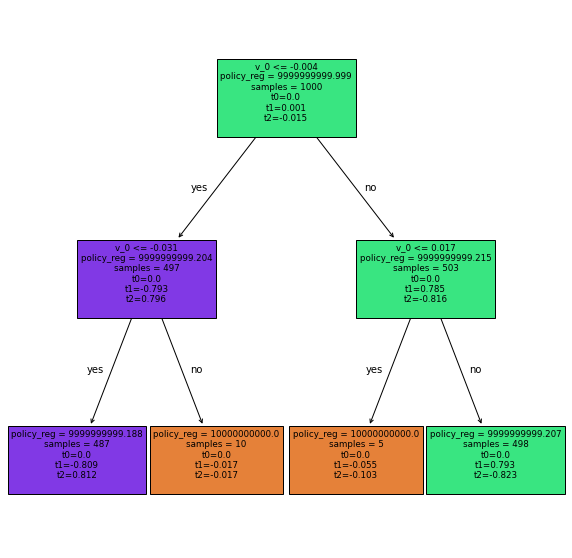

In [17]:
pit3 = PolicyInterpreter(max_depth=2,)
pit3.fit(
    data=dt,
    est_model=dml,
    covariate=covariate,
    treatment_names=['t0', 't1', 't2']
)
pit3.plot()
plt.show()

## Single binary treatment.

### The dataset is generated by the following process
Below we use the einstein notation to alleviate the headaches of specifiying dimensions of tensors.
\begin{align*}
    x & \sim \text{Bernoulli}(f(w)), \quad f(w) = \sigma(w_i \beta^i + \eta), \quad \eta\sim \text{Uniform}(-1, 1) \\
    y & = x \theta(v^i) + \gamma_j w^j + \epsilon, \quad \epsilon \sim \text{Uniform}(-1, 1)\\
    w & \sim \text{Normal}(0, I_{n_w})\\
    v & \sim \text{Uniform}(0, 1)^{n_v}
\end{align*}

In [18]:
t = TLearner(
    model=GradientBoostingRegressor()
)
t.fit(
    data=data,
    outcome=outcome,
    treatment=treatment,
    covariate=adjustment,
)
t_pred = t.estimate(data=test_data, quantity=None)

In [19]:
from ylearn.effect_interpreter.policy_interpreter import PolicyInterpreter

In [20]:
p = PolicyInterpreter(max_depth=2)
p.fit(
    data=data,
    est_model=t,
)
policy = p.interpret(data=test_data)

In [21]:
for i in range(60, 62):
    print(f'the policy for the sample {i}\n --------------\n' + policy[f'sample_{i}'] + '\n')

In [22]:
p.plot()
plt.show()

In [23]:
for i in range(55, 60):
    print(f'the policy for the sample {i}\n --------------\n' + policy[f'sample_{i}'] + '\n')

08-24 15:04:33 I ylearn.p.policy_model.py 450 - Start building the policy tree with criterion PRegCriteria
08-24 15:04:33 I ylearn.p.policy_model.py 466 - Building the policy tree with splitter BestSplitter
08-24 15:04:33 I ylearn.p.policy_model.py 498 - Building the policy tree with builder DepthFirstTreeBuilder
